# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="install-packages"></a>Project Description</p>

    The description of the competition, and web page can be foud below:

https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="install-packages"></a>Goal of the Competition</p>

    Goal of the Competition Traumatic injury is the most common cause of death in the first four decades of life and a major public health problem around the world. There are estimated to be more than 5 million annual deaths worldwide from traumatic injury. Prompt and accurate diagnosis of traumatic injuries is crucial for initiating appropriate and timely interventions, which can significantly improve patient outcomes and survival rates. Computed tomography (CT) has become an indispensable tool in evaluating patients with suspected abdominal injuries due to its ability to provide detailed cross-sectional images of the abdomen.

    Interpreting CT scans for abdominal trauma, however, can be a complex and time-consuming task, especially when multiple injuries or areas of subtle active bleeding are present. This challenge seeks to harness the power of artificial intelligence and machine learning to assist medical professionals in rapidly and precisely detecting injuries and grading their severity. The development of advanced algorithms for this purpose has the potential to improve trauma care and patient outcomes worldwide.

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="install-packages"></a>Context</p>

    Blunt force abdominal trauma is among the most common types of traumatic injury, with the most frequent cause being motor vehicle accidents. Abdominal trauma may result in damage and internal bleeding of the internal organs, including the liver, spleen, kidneys, and bowel. Detection and classification of injuries are key to effective treatment and favorable outcomes. A large proportion of patients with abdominal trauma require urgent surgery. Abdominal trauma often cannot be diagnosed clinically by physical exam, patient symptoms, or laboratory tests.

    Prompt diagnosis of abdominal trauma using medical imaging is thus critical to patient care. AI tools that assist and expedite diagnosis of abdominal trauma have the potential to substantially improve patient care and health outcomes in the emergency setting.

    The RSNA Abdominal Trauma Detection AI Challenge, organized by the RSNA in collaboration with the American Society of Emergency Radiology (ASER) and the Society for Abdominal Radiology (SAR), gives researchers the task of building models that detect severe injury to the internal abdominal organs, including the liver, kidneys, spleen, and bowel, as well as any active internal bleeding.

# Table of Contents
1. [Install Packages](#install-packages)
2. [Variable Settings](#var-settings)
3. [Kaggle Setup](#kaggle-setup)
4. [Data Loading](#data-loading)
5. [Exploratory Data Analysis (EDA)](#eda)
6. [Preprocessing](#preprocessing)
7. [Training](#training)
8. [Inference](#inference)
9. [Model Evaluation](#model-evaluation)


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="install-packages"></a>Install Packages</p>

In [ ]:
# ! pip install -q git+https://github.com/keras-team/keras-cv

In [81]:
# Install Packages
import subprocess

def install_package(package_name, extra_command=None):
    """
    Install a Python package using pip and return 'Success' or 'Fail' message.
    
    Args:
        package_name (str): The name of the package to install.
        extra_command (str, optional): Extra commands to add to the pip install command.
    
    Returns:
        str: 'Success' if the package was successfully installed, 'Fail' otherwise.
    """
    try:
        cmd = f"pip install {package_name} {extra_command}"
        result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, text=True)
        if result.returncode == 0:
            return 'Success'
        else:
            return 'Fail'
    except Exception as e:
        return 'Fail'

packages_to_install = ['tensorflow', 'keras_tuner', 'tensorflow_io', 'kaggle', 'nibabel',
                       'pydicom', 'opencv-python', 'matplotlib', 'pandas', 'scikit-image', 
                       'numpy', 'scikit-learn', 'scipy', 'seaborn', 'natsort', 'shutup']

for package in packages_to_install:
    print(f"Installing {package}: {install_package(package)}")


Installing tensorflow: Success
Installing keras_tuner: Success
Installing tensorflow_io: Success
Installing kaggle: Success
Installing nibabel: Success
Installing pydicom: Success
Installing opencv-python: Success
Installing matplotlib: Success
Installing pandas: Success
Installing scikit-image: Success
Installing numpy: Success
Installing scikit-learn: Success
Installing scipy: Success
Installing seaborn: Success
Installing natsort: Success
Installing shutup: Success


In [221]:
import shutup; shutup.please()
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras_tuner as kt
import pydicom
import nibabel as nib

# import train/test split
from sklearn.model_selection import train_test_split


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="var-settings"></a>Variable Settings</p>

In [84]:
# Variable Settings
competition_name = "rsna-2023-abdominal-trauma-detection"

# download_dir = "/path/to/download"
# zip_file = "dataset.zip"


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="kaggle-setup"></a>Kaggle Setup</p>

In [93]:
import os
import zipfile

def download_dataset(competition_name=None, flag=None):
    """
    Download a dataset from Kaggle.
    """
    if competition_name is None:
        competition_name = input("Enter the competition or dataset name: ")

    # Download the dataset
    if flag == 'comp':
        os.system(f'kaggle competitions download -c {competition_name}')
    elif flag == 'dataset':
        os.system(f'kaggle datasets download -d {competition_name}')

def unzip_all_datasets():
    """
    Unzip all zip files in the current directory and display a message indicating success or failure for each.
    """
    # List all files in the current directory
    files = os.listdir()

    # Find all zip files in the directory
    zip_files = [file for file in files if file.endswith('.zip')]

    if not zip_files:
        print("No zip files found in the current directory.")
        return

    for zip_file in zip_files:
        # Extract each zip file to a directory with the same name as the zip file (excluding the extension)
        extract_directory = os.path.splitext(zip_file)[0]

        # Check if the extraction directory already exists
        if os.path.exists(extract_directory):
            print(f"'{extract_directory}' already exists. Skipping extraction for '{zip_file}'.")
            continue

        try:
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(extract_directory)
            print(f"Extraction successful for '{zip_file}'. Files are in '{extract_directory}' directory.")
        except Exception as e:
            print(f"Extraction failed for '{zip_file}': {str(e)}")

if __name__ == "__main__":
    download_dataset()
    unzip_dataset()


In [91]:
# download supplemental datasets

download_dataset(competition_name = "johndonz12/png-datset", flag='dataset')
download_dataset(competition_name = "tobetek/rsna-atd-2023-dicom-metadata", flag='dataset')

100%|█████████▉| 873M/874M [03:12<00:00, 6.88MB/s] 

100%|██████████| 874M/874M [03:13<00:00, 4.75MB/s]


 98%|█████████▊| 57.0M/57.9M [00:09<00:00, 5.11MB/s]

100%|██████████| 57.9M/57.9M [00:09<00:00, 6.43MB/s]


In [94]:
unzip_all_datasets()

'rsna-atd-2023-dicom-metadata' already exists. Skipping extraction for 'rsna-atd-2023-dicom-metadata.zip'.
Extraction successful for 'png-datset.zip'. Files are in 'png-datset' directory.


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="data-loading"></a>Data Loading</p>

In [ ]:
# Data Loading
# Placeholder for data loading code


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="data-loading"></a>Convert Dicom Images to PNG</p>

In [98]:
!pip install -qU python-gdcm pydicom pylibjpeg

In [99]:
import os
import cv2
import glob
import gdcm
import pydicom
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from joblib import Parallel, delayed
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [100]:
def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    """
    Source : https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    """
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
#         pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)

    intercept = float(dcm.RescaleIntercept)
    slope = float(dcm.RescaleSlope)
    center = int(dcm.WindowCenter)
    width = int(dcm.WindowWidth)
    low = center - width / 2
    high = center + width / 2    
    
    pixel_array = (pixel_array * slope) + intercept
    pixel_array = np.clip(pixel_array, low, high)

    return pixel_array

In [101]:
# TRAIN_PATH = "/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/"
TRAIN_PATH = "/home/jack/github/rsna/data/train_images/"

# TEST_PATH = "/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/"

print('Number of training patients :', len(os.listdir(TRAIN_PATH)))

# print('Number of test patients :', len(os.listdir(TEST_PATH)))

Number of training patients : 1


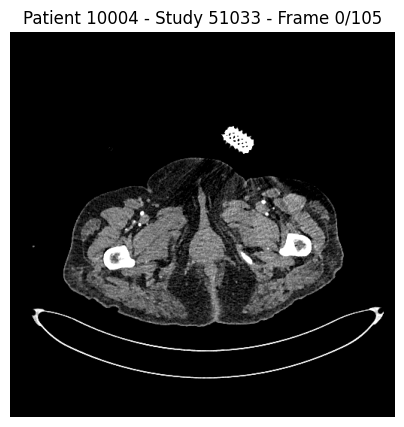

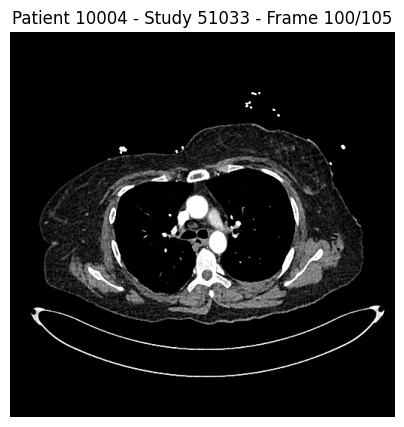

In [102]:
for patient in sorted(os.listdir(TRAIN_PATH)):
    for study in os.listdir(TRAIN_PATH + patient):
        imgs = {}
        for f in sorted(glob.glob(TRAIN_PATH + f"{patient}/{study}/*.dcm"))[::10]:
            dicom = pydicom.dcmread(f)

            pos_z = dicom[(0x20, 0x32)].value[-1]  # to retrieve the order of frames

            img = standardize_pixel_array(dicom)
            img = (img - img.min()) / (img.max() - img.min() + 1e-6)

            if dicom.PhotometricInterpretation == "MONOCHROME1":
                img = 1 - img

            imgs[pos_z] = img

        for i, k in enumerate(sorted(imgs.keys())):
            img = imgs[k]
            
            if not (i % 100):
                plt.figure(figsize=(5, 5))
                plt.imshow(img, cmap="gray")
                plt.title(f"Patient {patient} - Study {study} - Frame {i}/{len(imgs)}")
                plt.axis(False)
                plt.show()
    
        break
    break

In [103]:
def process(patient, size=512, save_folder="", data_path=""):
    for study in sorted(os.listdir(data_path + patient)):
        imgs = {}
        for f in sorted(glob.glob(data_path + f"{patient}/{study}/*.dcm")):
            dicom = pydicom.dcmread(f)

            pos_z = dicom[(0x20, 0x32)].value[-1]

            img = standardize_pixel_array(dicom)
            img = (img - img.min()) / (img.max() - img.min() + 1e-6)

            if dicom.PhotometricInterpretation == "MONOCHROME1":
                img = 1 - img

            imgs[pos_z] = img

        for i, k in enumerate(sorted(imgs.keys())):
            img = imgs[k]

            if size is not None:
                img = cv2.resize(img, (size, size))

            if isinstance(save_folder, str):
                cv2.imwrite(save_folder + f"{patient}_{study}_{i}.png", (img * 255).astype(np.uint8))
            else:
                im = cv2.imencode('.png', (img * 255).astype(np.uint8))[1]
                save_folder.writestr(f'{patient}_{study}_{i:04d}.png', im)

In [104]:
patients = os.listdir(TRAIN_PATH)

# Chunking
patients = (
    patients[:400],
    patients[400:  800],
    patients[800:  1200],
    patients[1200: 1600],
    patients[1600: 2000],
    patients[2000: 2400],
    patients[2400: 2800],
    patients[2800:],
)

# patients = patients[0]  # [:10]  # subsample
counter = 0
for patient in patients:
    
    counter += len(patient)
print(counter)
    

1


In [110]:
with zipfile.ZipFile("train.zip", 'w') as save_folder:
    for patient_list in tqdm(patients):
        # Ensure patient is treated as a string
        if isinstance(patient_list, list):
            # Join the list elements into a single string
            patient = ''.join(patient_list)
        else:
            patient = patient_list
        process(patient, size=None, save_folder=save_folder, data_path=TRAIN_PATH)


100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


In [ ]:
patients = os.listdir(TEST_PATH)

with zipfile.ZipFile("test.zip", 'w') as save_folder:
    for patient in tqdm(patients):
        process(patient, size=None, save_folder=save_folder, data_path=TEST_PATH)

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="eda"></a>Exploratory Data Analysis (EDA)</p>

In [111]:
def load_dcm(path):
    dcm = pydicom.dcmread(path)
    data = dcm.pixel_array

    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = data.dtype
        data = (data << bit_shift).astype(dtype) >> bit_shift

    # Scans are B&W
    if dcm.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    # Min-Max Normalization
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

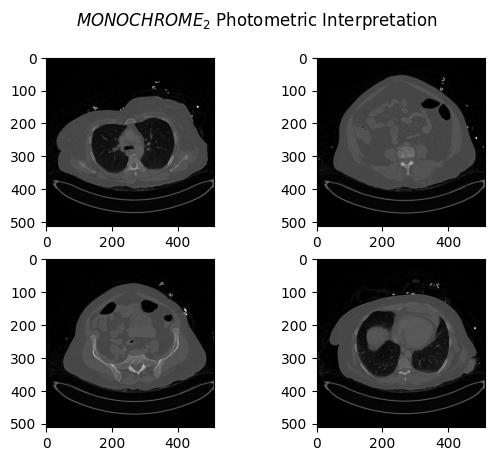

In [114]:
from PIL import Image
from pathlib import Path

DATA_DIR = Path('data/')

fig, axes = plt.subplots(2, 2)
axes = iter(axes.flat)
fig.suptitle("$MONOCHROME_2$ Photometric Interpretation")
for file in list(DATA_DIR.joinpath("train_images/10004/21057").iterdir())[
    :4
]:
    random_img = load_dcm(file)
    ax = next(axes)
    # The correct interpretation of MONOCHROME_2
    ax.imshow(random_img, cmap="Greys_r")

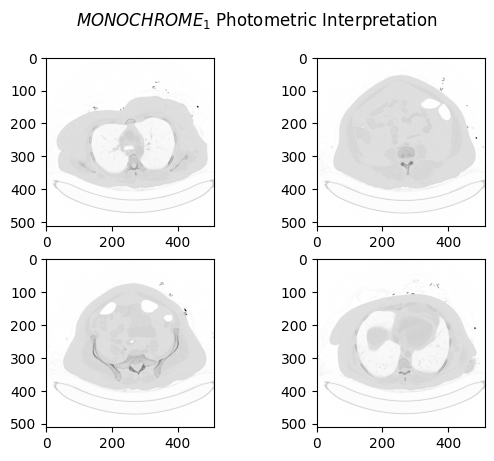

In [115]:
from PIL import Image

fig, axes = plt.subplots(2, 2)
axes = iter(axes.flat)
fig.suptitle("$MONOCHROME_1$ Photometric Interpretation")

for file in list(DATA_DIR.joinpath("train_images/10004/21057").iterdir())[:4]:
    random_img = load_dcm(file)
    ax = next(axes)
    ax.imshow(random_img, cmap="Greys")

In [118]:
train_df = pd.read_csv('/home/jack/github/rsna/data/train.csv')
train_meta_df = pd.read_csv('/home/jack/github/rsna/data/train_series_meta.csv')
train_df = train_df.merge(train_meta_df)

In [119]:
print('Number of Patients in the Study: ', len(train_df.patient_id.unique()))

Number of Patients in the Study:  3147


In [120]:
# Confirm that each injury_type is mutually exclusive to injury_health
BINARY_INJURIES = ["bowel", "extravasation"]
TERNARY_INJURIES = ["kidney", "spleen", "liver"]

Text(0.5, 1.0, "Percentage of Patients' with Abdominal Injuries")

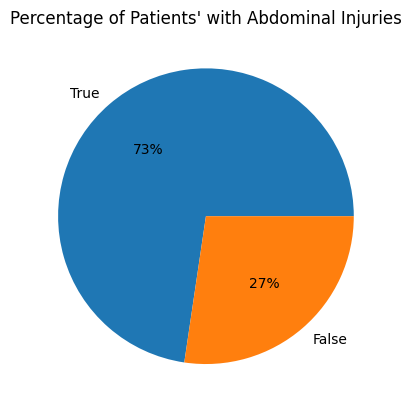

In [121]:
plt.pie(
    train_df.any_injury.value_counts(),
    labels=train_df.any_injury.unique().astype(bool),
    autopct="%.0f%%",
)
plt.title("Percentage of Patients' with Abdominal Injuries")

Text(0.5, 1.0, 'Distribution of different kinds of Abdominal Injuries')

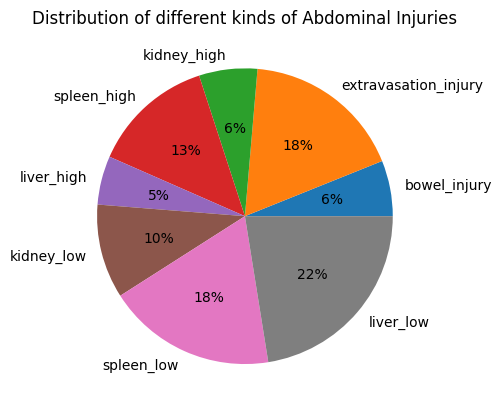

In [122]:
all_injuries = (
    train_df[[f"{injury}_injury" for injury in BINARY_INJURIES]].sum().to_dict()
    | train_df[[f"{injury}_high" for injury in TERNARY_INJURIES]].sum().to_dict()
    | train_df[[f"{injury}_low" for injury in TERNARY_INJURIES]].sum().to_dict()
)
plt.pie(
    all_injuries.values(),
    labels=all_injuries.keys(),
    autopct="%.0f%%",
)
plt.title("Distribution of different kinds of Abdominal Injuries")

In [123]:
# Exploratory Data Analysis (EDA)
DICOM_META_DIR = Path("/home/jack/github/rsna/rsna-atd-2023-dicom-metadata/")
dicom_meta_df = pd.read_csv(DICOM_META_DIR.joinpath("train_images_dicom_meta.csv"))
dicom_meta_df.sample(5)

,sop instance uid,content date,content time,patient id,slice thickness,kvp,patient position,study instance uid,series instance uid,series number,...,pixel representation,window center,window width,rescale intercept,rescale slope,_patient_id,_series_id,_scan_id,_image_index,rescale type
125884,1.2.123.12345.1.2.3.23979.1.178,20230721,234303.822344,23979,2.00,120.0,HFS,1.2.123.12345.1.2.3.23979,1.2.123.12345.1.2.3.23979.629,4,...,0,50.0,400.0,-1024.0,1.0,23979,629,178,97,HU
699519,1.2.123.12345.1.2.3.40633.1.586,20230722,2435.667160,40633,1.00,100.0,FFS,1.2.123.12345.1.2.3.40633,1.2.123.12345.1.2.3.40633.23522,6,...,1,50.0,400.0,0.0,1.0,40633,23522,586,462,NaN
598686,1.2.123.12345.1.2.3.45773.1.51,20230722,1930.362154,45773,3.00,120.0,HFS,1.2.123.12345.1.2.3.45773,1.2.123.12345.1.2.3.45773.23007,9,...,0,50.0,400.0,-1024.0,1.0,45773,23007,51,50,HU
486358,1.2.123.12345.1.2.3.53186.1.628,20230722,3738.097014,53186,1.25,120.0,FFS,1.2.123.12345.1.2.3.53186,1.2.123.12345.1.2.3.53186.46538,303,...,1,50.0,400.0,-1024.0,1.0,53186,46538,628,355,HU
906354,1.2.123.12345.1.2.3.48210.1.287,20230722,2331.825723,48210,1.00,120.0,HFS,1.2.123.12345.1.2.3.48210,1.2.123.12345.1.2.3.48210.36641,1,...,0,50.0,400.0,-1024.0,1.0,48210,36641,287,7,HU


Text(0.5, 1.0, 'Average Slice Thickness Used by Patients')

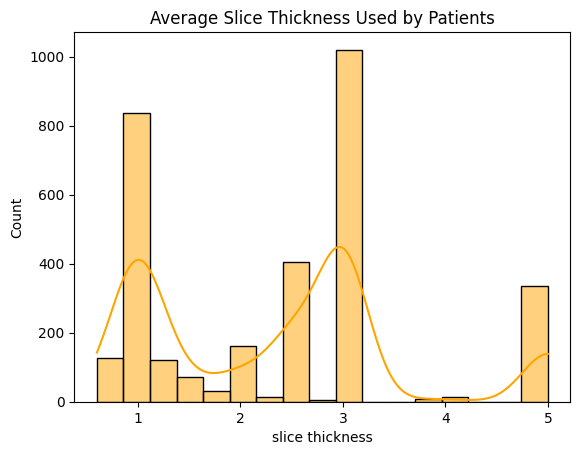

In [124]:
# The average slice thickness used for each patient

sns.histplot(
    dicom_meta_df.groupby("patient id")["slice thickness"].mean(),
    kde=True,
    color="orange",
)
plt.title("Average Slice Thickness Used by Patients")

Text(0.5, 1.0, 'Patient Scan Position')

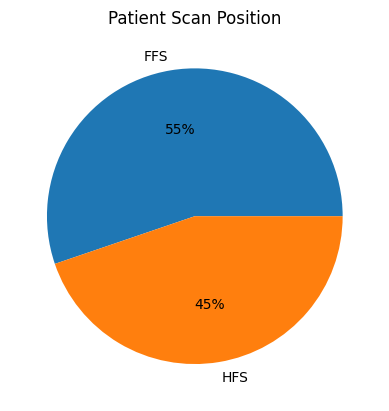

In [125]:
patient_positions = dicom_meta_df.groupby("patient id")["patient position"].max()

plt.pie(
    patient_positions.value_counts(),
    labels=patient_positions.value_counts().index,
    autopct="%.0f%%",
)
plt.title("Patient Scan Position")

Text(0.5, 1.0, 'Number of scans done by each patient in a series')

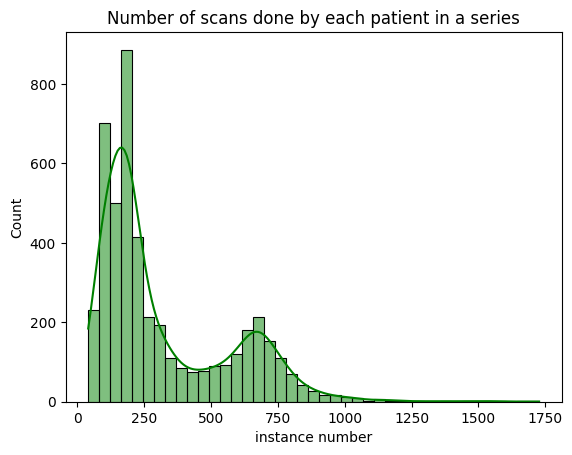

In [126]:
sns.histplot(
    dicom_meta_df.groupby(by=["patient id", "series number"])[
        "instance number"
    ].count(),
    kde=True,
    color="green",
)
plt.title("Number of scans done by each patient in a series")

In [129]:
COMPETITION_DATA_DIR = Path("/home/jack/github/rsna//home/jack/github/rsna/data/")

In [162]:
from matplotlib import animation
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from skimage.measure import find_contours
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import HTML

SEGMENTATION_CODES = {
    1: "liver",
    2: "spleen",
    3: "kidney_left",
    4: "kidney_right",
    5: "bowel",
}

SEGMENTATION_CODES_REVERSED = {value: key for key, value in SEGMENTATION_CODES.items()}

SEGMENTATION_CMAP = plt.get_cmap("rainbow")
SEGMENTATION_PALETTE = np.array(
    [[np.nan] * 4] + [SEGMENTATION_CMAP(x) for x in np.linspace(0, 1, 6)]
)


def generate_injuries_img(seg_img, series_id):
    injury_img = seg_img.copy()
    patient_results = train_df[train_df["series_id"] == series_id].iloc[0].astype(bool)
    injured_organs = {
        SEGMENTATION_CODES_REVERSED["liver"]: ~patient_results.liver_healthy,
        SEGMENTATION_CODES_REVERSED["spleen"]: ~patient_results.spleen_healthy,
        SEGMENTATION_CODES_REVERSED["kidney_left"]: ~patient_results.kidney_healthy,
        SEGMENTATION_CODES_REVERSED["kidney_right"]: ~patient_results.kidney_healthy,
        SEGMENTATION_CODES_REVERSED["bowel"]: ~patient_results.bowel_healthy,
    }

    msk = np.vectorize(lambda x: injured_organs.get(x, False))(injury_img)
    injury_img[msk] = 10  # Random constant picked for clarity
    injury_img[~msk] = 0  # Random constant picked for clarity
    return injury_img


def plot_img(series_img, seg_img, injury_img, ax):
    series_img = load_dcm(series_img)
    series_img = series_img
    seg_img_coloured = SEGMENTATION_PALETTE[seg_img]

    ax.imshow(series_img, cmap="Greys_r")
    ax.imshow(seg_img_coloured, alpha=0.5)

    contours = find_contours(injury_img, 0)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, c="r")

    return {"scan_img": series_img, "seg_img": "seg_img_coloured"}


def plot_legend(ax):
    #     mask_levels = [x for x in np.unique(seg_img) if x != 0]
    legend_elements = [
        Patch(
            facecolor=SEGMENTATION_PALETTE[x],
            edgecolor=SEGMENTATION_PALETTE[x],
            label=SEGMENTATION_CODES[x],
        )
        for x in SEGMENTATION_CODES.keys()
    ]
    ax.legend(handles=legend_elements, loc="upper right")


def load_series_segmentation(series_id):
    seg = nib.load(COMPETITION_DATA_DIR.joinpath(f"segmentations/{series_id}.nii"))
    seg = nib.as_closest_canonical(seg)  # Ensures output is RAS, DICOM is LPS.
    return seg.get_fdata().astype(int)[::-1, ::-1, :]  # Reverse to match Z order

In [200]:
COMPETITION_DATA_DIR = Path("/home/jack/github/rsna/data/")

In [201]:
unique  = dicom_meta_df['_patient_id'].unique()

In [237]:
from IPython.display import HTML


def visualize_patient_series(patient_id, no_frames=50):
    # Filter the DataFrame to get rows with the specified series_id
    patient_rows = dicom_meta_df[dicom_meta_df["_patient_id"] == patient_id]
    
    # Check if there are any rows
    if len(patient_rows) == 0:
        print(f"No rows found for patient_id {patient_id}.")
        return
    
    # Get the unique patient_id values from the filtered rows
    series_ids = patient_rows["_series_id"].unique()
    
    # Check if there are any patient_ids
    if len(series_ids) == 0:
        print(f"No unique series_id found for patient_id {patient_id}.")
        return
    
    # Take the first patient_id
    series_id = series_ids[0]
    
    scans = list(
        COMPETITION_DATA_DIR.joinpath(
            f"train_images/{patient_id}/{series_id}/"
        ).iterdir()
    )
    
    scans = list(
        sorted(scans, key=lambda f: int("".join([c for c in f.name if c.isdigit()])))
    )
    
    segmentations = load_series_segmentation(series_id)

    no_scans = len(scans)
    indx_scans_to_display = iter(range(no_scans)[:: no_scans // no_frames])

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    plot_legend(ax)

    series_img = load_dcm(scans[0])
    seg_img = segmentations[:, :, -1].T

    injury_img = generate_injuries_img(seg_img, series_id)
    seg_img_coloured = SEGMENTATION_PALETTE[seg_img]

    fig_scan_img = ax.imshow(series_img, cmap="Greys_r")
    fig_seg_img = ax.imshow(seg_img_coloured, alpha=0.5)

    contours = find_contours(injury_img, 0)
    fax_c = {}
    
    for indx, contour in enumerate(contours):
        fax_c[indx] = ax.plot(contour[:, 1], contour[:, 0], linewidth=4, c="r")

    def update_animation(img_num, *args, **kwargs):
        img_indx = next(indx_scans_to_display)

        # Clear the figure to remove previous content
        ax.clear()

        seg_img = segmentations[:, :, -(img_indx + 1)].T
        seg_img_coloured = SEGMENTATION_PALETTE[seg_img]

        series_img = load_dcm(scans[img_indx])

        fig_scan_img = ax.imshow(series_img, cmap="Greys_r")
        fig_seg_img = ax.imshow(seg_img_coloured, alpha=0.5)

        injury_img = generate_injuries_img(seg_img, series_id)
        contours = find_contours(injury_img, 0)

        for indx, contour in enumerate(contours):
            ax.plot(contour[:, 1], contour[:, 0], linewidth=4, c="r")

        return [fig_scan_img, fig_seg_img]

    
    # Create the animation
    amn = animation.FuncAnimation(
        fig, update_animation, frames=no_frames, repeat=True, repeat_delay=50000
    )



    # Save the animation as a GIF
    animation_filename = 'animation.gif'
    amn.save(animation_filename, writer='pillow')

    # Embed the saved animation in the notebook
    return HTML(f'<img src="{animation_filename}" />')


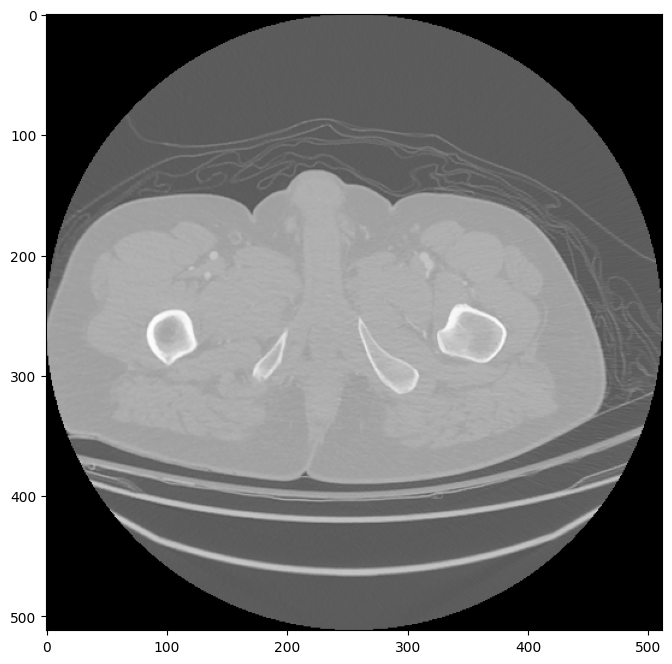

In [238]:
import warnings
# Suppress the warning
warnings.filterwarnings("ignore", category=RuntimeWarning)


visualize_patient_series(54183, no_frames=50)

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="preprocessing"></a>Preprocessing</p>

In [131]:
# Preprocessing
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 64
    EPOCHS = 200
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

In [132]:
tf.keras.utils.set_random_seed(seed=config.SEED)

In [137]:
BASE_PATH = f"/home/jack/github/rsna/png-datset"

In [140]:
# Add a flag to toggle between the full dataset and a subset
use_small_data = True  # Set to False for the full dataset

# Fraction of data to use when use_small_data is True
data_fraction = 0.35  # 10% of the data

# train
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")

# Subset the data if use_small_data is True
if use_small_data:
    dataframe = dataframe.sample(frac=data_fraction).reset_index(drop=True)

dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

train_data.shape, val_data.shape

((3543, 21), (902, 21))

In [141]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.cast(label, tf.float32)
    #         bowel       fluid       kidney      liver       spleen
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])

    return (image, labels)



def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [142]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

2023-10-18 14:16:48.076891: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-10-18 14:16:48.076913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: jack
2023-10-18 14:16:48.076917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: jack
2023-10-18 14:16:48.077029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.104.5
2023-10-18 14:16:48.077042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.86.5
2023-10-18 14:16:48.077045: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 535.86.5 does not match DSO version 535.104.5 -- cannot find working devices in this configuration


(TensorShape([64, 256, 256, 3]),
 [TensorShape([64, 1]),
  TensorShape([64, 1]),
  TensorShape([64, 3]),
  TensorShape([64, 3]),
  TensorShape([64, 3])])

In [143]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Initialize callbacks
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

callbacks = [model_checkpoint, early_stopping]

In [144]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)


# Calculate total steps based on the actual dataset being used
total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=716800
warmup_steps=71680
decay_steps=645120


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="training"></a>Training</p>

In [145]:
preprocess_input_vgg = tf.keras.applications.vgg16.preprocess_input

def build_model_vgg16(hp):
    
    data_augmentation_vgg16 = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.05),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.05),
        tf.keras.layers.GaussianNoise(0.1)])
    
        
    # Define the Input tensor
    input_tensor = tf.keras.Input(shape=(256, 256, 3))
        
    # Use the input_tensor in VGG16 backbone
    backbone = tf.keras.applications.VGG16(
        include_top=False,
        weights="imagenet",
        input_tensor=input_tensor,
        pooling=None)

    for layer in backbone.layers:
        layer.trainable = False

    n_hidden = hp.Int("n_hidden", min_value=1, max_value=6, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=300, step=16)
    learning_rate = hp.Float("learning_rate", min_value=1e-7, max_value=1e-4, sampling="log")
    dropout_rate = hp.Float("dropout_rate", min_value=0.0, max_value=0.5, step=0.05)
    l2_reg = hp.Float("l2_reg", min_value=1e-6, max_value=1e-2, sampling="log")
    
    # After the Flatten layer
    model = tf.keras.models.Sequential([
        data_augmentation_vgg16,
        tf.keras.layers.Lambda(preprocess_input_vgg), # Preprocess input for VGG
        backbone,
        tf.keras.layers.Flatten()
    ])

    # GAP to get the activation maps
    x = backbone.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Define 'necks' for each head
    x_bowel = tf.keras.layers.Dense(hp.Int("dense_bowel", min_value=16, max_value=128, step=16), activation='relu')(x)
    x_extra = tf.keras.layers.Dense(hp.Int("dense_extra", min_value=16, max_value=128, step=16), activation='relu')(x)
    x_liver = tf.keras.layers.Dense(hp.Int("dense_liver", min_value=16, max_value=128, step=16), activation='relu')(x)
    x_kidney = tf.keras.layers.Dense(hp.Int("dense_kidney", min_value=16, max_value=128, step=16), activation='relu')(x)
    x_spleen = tf.keras.layers.Dense(hp.Int("dense_spleen", min_value=16, max_value=128, step=16), activation='relu')(x)

    # Define heads
    out_bowel = tf.keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel)
    out_extra = tf.keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra)
    out_liver = tf.keras.layers.Dense(3, name='liver', activation='softmax')(x_liver)
    out_kidney = tf.keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney)
    out_spleen = tf.keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen)

    # Constructing final model - use input_tensor
    final_model = tf.keras.Model(inputs=input_tensor, outputs=[out_bowel, out_extra, out_liver, out_kidney, out_spleen])

    # Compile the model with multiple outputs
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    loss = {
        "bowel": tf.keras.losses.BinaryCrossentropy(),
        "extra": tf.keras.losses.BinaryCrossentropy(),
        "liver": tf.keras.losses.CategoricalCrossentropy(),
        "kidney": tf.keras.losses.CategoricalCrossentropy(),
        "spleen": tf.keras.losses.CategoricalCrossentropy(),
    }
    metrics = {
        "bowel": ["accuracy"],
        "extra": ["accuracy"],
        "liver": ["accuracy"],
        "kidney": ["accuracy"],
        "spleen": ["accuracy"],
    }

    final_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return final_model


In [147]:
tuner = kt.BayesianOptimization(
    build_model_vgg16,
    objective='val_loss',
    max_trials=1,
    # num_initial_points= 3,
    seed=1,
    overwrite=True,
    directory='tuner',
    project_name='bayes'
)


tuner.search(train_ds, epochs=2, validation_data=val_ds, callbacks = callbacks)

best_model = tuner.get_best_models(num_models=1)[0]

best_model.save('best_classification.h5')

Trial 1 Complete [00h 10m 13s]
val_loss: 6.835134029388428

Best val_loss So Far: 6.835134029388428
Total elapsed time: 00h 10m 13s


## Train best model on the full data

In [148]:
# Add a flag to toggle between the full dataset and a subset
use_small_data = False  # Set to False for the full dataset

# Fraction of data to use when use_small_data is True
data_fraction = 0.35  # 10% of the data

# train
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")

# Subset the data if use_small_data is True
if use_small_data:
    dataframe = dataframe.sample(frac=data_fraction).reset_index(drop=True)

dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
full_train_data = pd.DataFrame()
full_val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    full_train_group, full_val_group = split_group(group)
    full_train_data = pd.concat([full_train_data, full_train_group], ignore_index=True)
    full_val_data = pd.concat([full_val_data, full_val_group], ignore_index=True)

full_train_data.shape, full_val_data.shape

((9612, 21), (2417, 21))

In [149]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = full_train_data.image_path.values; train_labels = full_train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = full_val_data.image_path.values; valid_labels = full_val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
full_train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
full_val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)


# Calculate total steps based on the actual dataset being used
total_train_steps = full_train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=1932800
warmup_steps=193280
decay_steps=1739520


In [150]:
# Train on full data

loaded_model = tf.keras.models.load_model("best_classification.h5")

# Train the model on the full dataset
history = loaded_model.fit(full_train_ds,
                           epochs=2,
                           validation_data= full_val_ds,
                           callbacks=callbacks)

Epoch 1/2
151/151 [==============================] - 795s 5s/step - loss: 6.7952 - bowel_loss: 0.7267 - extra_loss: 1.0301 - liver_loss: 1.7316 - kidney_loss: 1.7512 - spleen_loss: 1.5557 - bowel_accuracy: 0.5214 - extra_accuracy: 0.3034 - liver_accuracy: 0.0529 - kidney_accuracy: 0.1597 - spleen_accuracy: 0.1411 - val_loss: 6.7440 - val_bowel_loss: 0.7268 - val_extra_loss: 1.0255 - val_liver_loss: 1.7203 - val_kidney_loss: 1.7308 - val_spleen_loss: 1.5405 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.3033 - val_liver_accuracy: 0.0534 - val_kidney_accuracy: 0.1605 - val_spleen_accuracy: 0.1386
Epoch 2/2


/home/jack/github/rsna/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 798s 5s/step - loss: 6.7059 - bowel_loss: 0.7254 - extra_loss: 1.0214 - liver_loss: 1.7119 - kidney_loss: 1.7193 - spleen_loss: 1.5279 - bowel_accuracy: 0.5214 - extra_accuracy: 0.3034 - liver_accuracy: 0.0529 - kidney_accuracy: 0.1597 - spleen_accuracy: 0.1406 - val_loss: 6.6661 - val_bowel_loss: 0.7268 - val_extra_loss: 1.0181 - val_liver_loss: 1.7026 - val_kidney_loss: 1.7026 - val_spleen_loss: 1.5160 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.3033 - val_liver_accuracy: 0.0534 - val_kidney_accuracy: 0.1605 - val_spleen_accuracy: 0.1398


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="model-evaluation"></a>Model Evaluation</p>

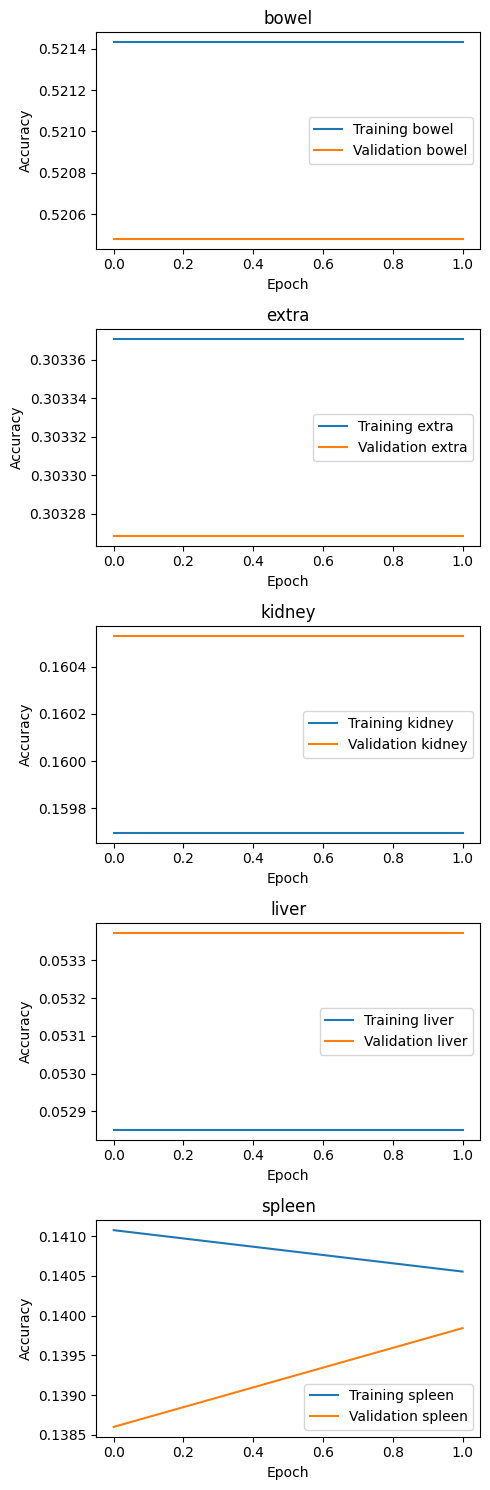

In [151]:
# Model Evaluation

# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

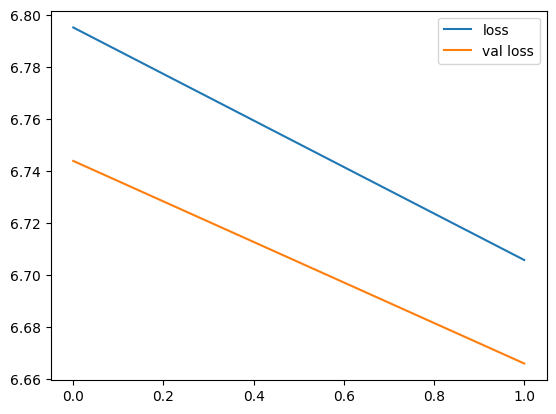

In [152]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [153]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

>>>> BEST Loss  : 6.666
>>>> BEST Acc   : 0.235
>>>> BEST Epoch : 1

ORGAN Acc:
  >>>> Bowel           : 0.520
  >>>> Extravasation   : 0.303
  >>>> Liver           : 0.053
  >>>> Kidney          : 0.161
  >>>> Spleen          : 0.140


In [ ]:
# Save the model
loaded_model.save("rsna_loaded.h5")

In [ ]:
# from google.colab import files
# files.download('rsna_loaded.h5')

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="inference"></a>Inference</p>

In [ ]:
# Inference
# Placeholder for inference code
